<a href="https://colab.research.google.com/github/harnalashok/deeplearning/blob/main/tabular_data_generation_using_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# LAst amended: 7th Oct, 2023
# Kaggle ref: https://www.kaggle.com/code/techytushar/tabular-data-generation-using-gans


## What is label smoothing

Label smoothing:  
>	Turns “hard” class label assignments to “soft” label assignments.  
>	Operates directly on the labels themselves.  
>	Is dead simple to implement.  
>	Can lead to a model that generalizes better.  

For example, let’s consider the following image from the MNIST dataset:

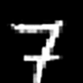

This digit is clearly a “7”, and if we were to write out the one-hot encoded label vector for this data point it would look like the following:  
[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, **1.0**, 0.0, 0.0]  
This is hard label assignment. Every entry is 0 except for the 8th index. If we were to apply soft label assignment to our one-hot encoded vector above it would now look like this:  
[0.01 0.01 0.01 0.01 0.01 0.01 0.01 0.91 0.01 0.01]


You can perform label smoothing using this formula:

> <i>new_labels = original_labels * (1 – label_smoothing) + label_smoothing /  num_classes </i>

Example: Imagine you have three classes with label_smoothing factor as 0.3.
Then, new_labels according to the above formula will be:  
= [0 1 2] * (1– 0.3) + ( 0.3 / 3 )  
= [0 1 2] * (0.7 )+ 0.1 = [ 0.1 0.8 1.5 ]    

Now, the new labels will be [0.1 0.8 1.5] instead of [0 1 2]

In [1]:
from google.colab import drive
drive.mount('/gdrive')

Mounted at /gdrive


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import precision_score, recall_score, f1_score,\
                            accuracy_score, classification_report,\
                            confusion_matrix

from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline

import os
from collections import Counter

np.random.seed(34)


In [3]:
pathToFolder = '/gdrive/MyDrive/Colab_data_files/creditcard/'
datafile = 'creditcardfraud.zip'

In [4]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

## Transform a sequential model to functional model

In [53]:
## AA
# Transform a Sequential model to Functional Model
# A sequential model
m1 = Sequential()
m1.add(Dense(4, activation = 'relu', input_dim = 4))
m1.add(Dense(4, activation = 'relu'))

# Specify the inputs now:
inputs = Input(shape = (4,))
# Get the output
# The output of our model:
s = m1(inputs)

# Our final model
mx = Model(inputs = inputs, outputs = s)
mx.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 4)]               0         
                                                                 
 sequential_9 (Sequential)   (None, 4)                 40        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [59]:
## BB.
#  A pure sequential model

m = Sequential()
m.add(Input(shape = (4)))
m.add(Input(shape = (4)))
m.add(Dense(4, activation = 'relu'))
m.add(Dense(4, activation = 'relu'))
m.summary()

Model: "sequential_12"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_14 (InputLayer)       multiple                  0         
                                                                 
 dense_25 (Dense)            (None, 4)                 20        
                                                                 
 dense_26 (Dense)            (None, 4)                 20        
                                                                 
Total params: 40 (160.00 Byte)
Trainable params: 40 (160.00 Byte)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


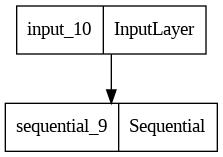

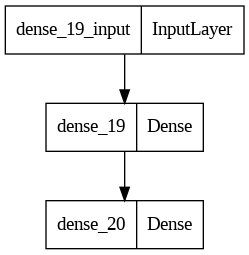

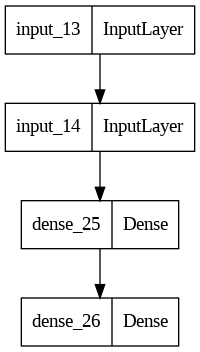

In [60]:
plot_model(mx)
print("=========")
plot_model(m1)
print("=========")
plot_model(m)


# Data Exploration and Cleaning

In [5]:
# reading data
df = pd.read_csv(pathToFolder + datafile)
df.drop("Time", 1, inplace=True)
print(df.shape)
df.head()

(284807, 30)


<ipython-input-5-5ce8c602f516>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop("Time", 1, inplace=True)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [6]:
# High class imbalance
df['Class'].value_counts(normalize=True)*100

0    99.827251
1     0.172749
Name: Class, dtype: float64

In [7]:
# Checking for Null values
print(f"Number of Null values: {df.isnull().any().sum()}")

Number of Null values: 0


In [8]:
# checking for duplicate values
print(f"Dataset has {df.duplicated().sum()} duplicate rows")
# dropping duplicate rows
df.drop_duplicates(inplace=True)

Dataset has 9144 duplicate rows


<Figure size 1400x400 with 0 Axes>

<Axes: >

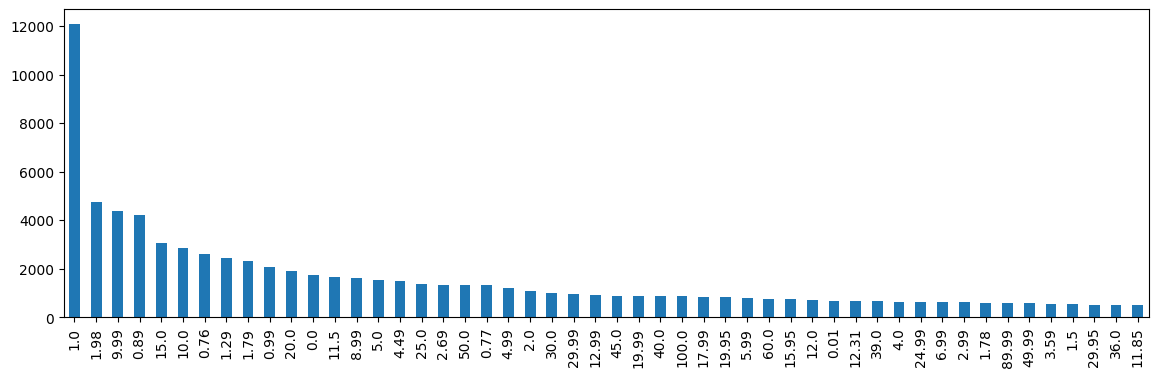

In [9]:
# high skweness in Amount feature
plt.figure(figsize=(14,4))
df['Amount'].value_counts().head(50).plot(kind='bar')
plt.show()

In [10]:
# checking skewness of other columns
df.drop('Class',1).skew()

<ipython-input-10-7c946d2c6350>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop('Class',1).skew()


V1        -3.273070
V2        -4.653486
V3        -2.216730
V4         0.681387
V5        -2.458790
V6         1.867576
V7         2.877722
V8        -8.292631
V9         0.550965
V10        1.242165
V11        0.347772
V12       -2.208171
V13        0.061058
V14       -1.953613
V15       -0.295836
V16       -1.048371
V17       -3.802987
V18       -0.255710
V19        0.115957
V20       -2.045060
V21        2.784302
V22       -0.200868
V23       -5.805236
V24       -0.545636
V25       -0.408260
V26        0.587603
V27       -0.745732
V28       11.400938
Amount    16.841622
dtype: float64

In [11]:
# taking log transform of high positively skewed features
skew_cols = df.drop('Class', 1).skew().loc[lambda x: x>2].index
for col in skew_cols:
    lower_lim = abs(df[col].min())
    normal_col = df[col].apply(lambda x: np.log10(x+lower_lim+1))
    print(f"Skew value of {col} after log transform: {normal_col.skew()}")

<ipython-input-11-5ab3fe925c19>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  skew_cols = df.drop('Class', 1).skew().loc[lambda x: x>2].index


Skew value of V7 after log transform: -14.073605361284569
Skew value of V21 after log transform: -19.018195679862643
Skew value of V28 after log transform: -11.293087825590737
Skew value of Amount after log transform: 0.1393219585866376


In [12]:
# Only applying log transform to Amount feature
df['Amount'] = df['Amount'].apply(lambda x: np.log10(x+1))

In [13]:
scaler = StandardScaler()
#scaler = MinMaxScaler()
X = scaler.fit_transform(df.drop('Class', 1))
y = df['Class'].values
print(X.shape, y.shape)

(275663, 29) (275663,)


<ipython-input-13-2d7fbdd8711a>:3: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X = scaler.fit_transform(df.drop('Class', 1))


In [14]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, stratify=y)

# Training a Baseline Model

In [ ]:
# simple linear regression
linear_model = LogisticRegression()
linear_model.fit(X_train, y_train)

y_pred = linear_model.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.81      0.64      0.71        47

    accuracy                           1.00     27567
   macro avg       0.91      0.82      0.86     27567
weighted avg       1.00      1.00      1.00     27567



In [ ]:
linear_model.classes_

array([0, 1])

# Using weighted regression to improve accuracy

In [ ]:
weights = np.linspace(0.05, 0.95, 15)

gscv = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid={
        'class_weight': [{0: x, 1: 1.0-x} for x in weights]
    },
    scoring='f1',
    cv=3
)
grid_res = gscv.fit(X, y)

print("Best parameters : %s" % grid_res.best_params_)

Best parameters : {'class_weight': {0: 0.11428571428571428, 1: 0.8857142857142857}}


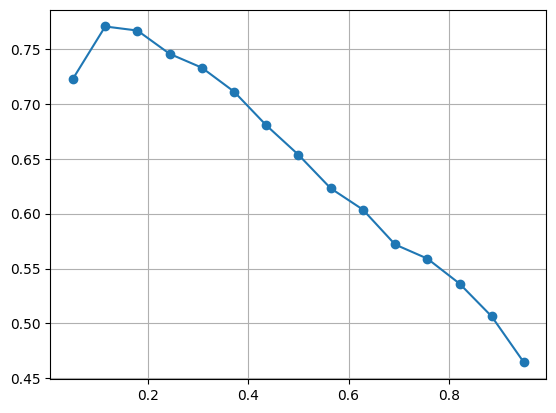

In [ ]:
# plotting F1 scores
plt.plot(weights, grid_res.cv_results_['mean_test_score'], marker='o')
plt.grid()
plt.show()

In [ ]:
# training with best weights
wlr = LogisticRegression(**grid_res.best_params_)
wlr.fit(X_train, y_train)

y_pred = wlr.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
#plot_confusion_matrix(wlr, X_test, y_test)
#plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.73      0.85      0.78        47

    accuracy                           1.00     27567
   macro avg       0.86      0.93      0.89     27567
weighted avg       1.00      1.00      1.00     27567



**Slight improvement when using weighted regression**

# Using SMOTE for upsampling

              precision    recall  f1-score   support

           0       1.00      0.97      0.99     27520
           1       0.06      0.96      0.11        47

    accuracy                           0.97     27567
   macro avg       0.53      0.97      0.55     27567
weighted avg       1.00      0.97      0.99     27567



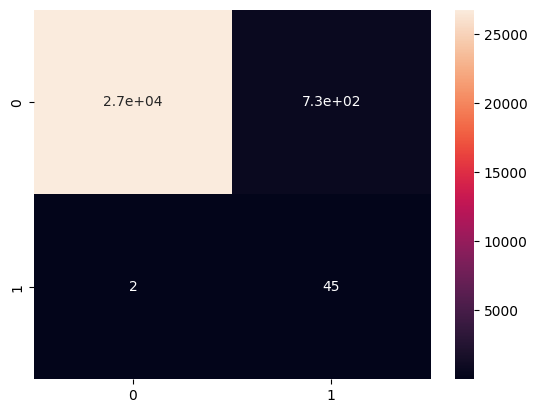

In [ ]:
# constructing pipeline
pipe = Pipeline([
        ('smote', SMOTE()),
        ('lr', LogisticRegression())
])
# training model with smote samples
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
plt.show()

**Poor F1 score even when using SMOTE**

# Grid Search on SMOTE and Regression

In [ ]:
pipe = Pipeline([
        ('smote', SMOTE()),
        ('lr', LogisticRegression())
])
sm_ratio = np.linspace(0.2, 0.8, 10)
lr_weights = np.linspace(0.05, 0.95, 10)

gscv = GridSearchCV(
    estimator=pipe,
    param_grid={
        'smote__sampling_strategy': sm_ratio,
        'lr__class_weight': [{0: x, 1: 1.0-x} for x in lr_weights]
    },
    scoring='f1',
    cv=3
)
grid_result = gscv.fit(X, y)

print("Best parameters : %s" % grid_result.best_params_)

Best parameters : {'lr__class_weight': {0: 0.95, 1: 0.050000000000000044}, 'smote__sampling_strategy': 0.2666666666666667}


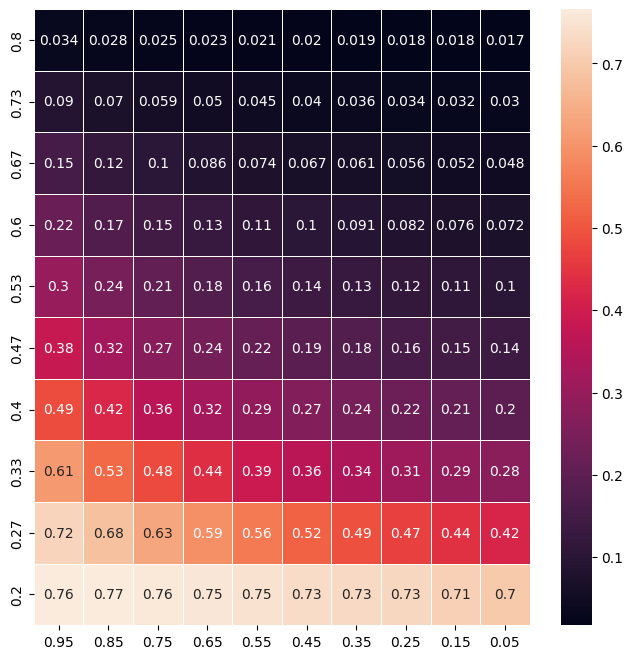

In [ ]:
df_gs = pd.DataFrame(data=grid_result.cv_results_['mean_test_score'].reshape(10,10),
                     index=np.around(sm_ratio[::-1], 2),
                     columns=np.around(lr_weights[::-1], 2))
plt.figure(figsize=(8,8))
sns.heatmap(df_gs,
            annot=True,
            linewidths=.5)
plt.show()

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     27520
           1       0.75      0.85      0.80        47

    accuracy                           1.00     27567
   macro avg       0.88      0.93      0.90     27567
weighted avg       1.00      1.00      1.00     27567



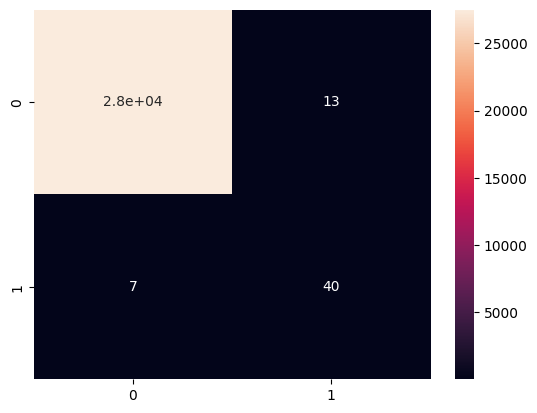

In [ ]:
# training with best weights
pipe = Pipeline([
        ('smote', SMOTE(sampling_strategy= 0.2)),
        ('lr', LogisticRegression(class_weight={0: 0.95, 1: 0.05}))
])
pipe.fit(X_train, y_train)

y_pred = pipe.predict(X_test)

# evaluation
print(classification_report(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred),annot=True)
plt.show()

**Using SMOTE with weighted regression improves results**

# Using GANs to generate new data

In [15]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Dense, Reshape, Flatten, Dropout, multiply, Concatenate
from tensorflow.keras.layers import BatchNormalization, Activation, Embedding, ZeroPadding2D, LeakyReLU
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal
from tensorflow.keras.utils import plot_model
import tensorflow.keras.backend as K
from sklearn.utils import shuffle

In [16]:
class cGAN():
    def __init__(self):
        self.latent_dim = 32
        self.out_shape = 29
        self.num_classes = 2
        self.clip_value = 0.01
        optimizer = tf.keras.optimizers.legacy.Adam(0.0002, 0.5)

        # build discriminator
        self.discriminator = self.build_discriminator()
        # Next compile it
        self.discriminator.compile(loss=['binary_crossentropy'],
                                   optimizer=optimizer,
                                   metrics=['accuracy']
                                   )

        # build generator
        self.generator = self.build_generator()

        # Generator is fed noise + labels
        noise = Input(shape=(self.latent_dim,))
        label = Input(shape=(1,))
        gen_samples = self.generator([noise, label])

        # When generated noise is fed, discriminator is not trained
        self.discriminator.trainable = False
        # passing gen samples through discriminator
        # Note that 'label' is being fed again. It is also
        # a part of gen_samples:
        valid = self.discriminator([gen_samples, label])

        # combining both generator and discriminator:
        self.combined = Model(
                              inputs = [noise, label],  # Feed to generator
                              outputs = valid           # Output of discriminator
                              )

        self.combined.compile(
                              loss=['binary_crossentropy'],
                              optimizer=optimizer,
                              metrics=['accuracy']
                              )

        self.combined.summary()

    def wasserstein_loss(self, y_true, y_pred):
        return K.mean(y_true * y_pred)

    def build_generator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)
        model = Sequential()

        model.add(Dense(128, input_dim=self.latent_dim))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(256))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(512))
        #model.add(Dropout(0.2))
        model.add(LeakyReLU(alpha=0.2))
        model.add(BatchNormalization(momentum=0.8))

        model.add(Dense(self.out_shape, activation='tanh'))
        model.summary()

        noise = Input(shape=(self.latent_dim,))   # First input to generator
        label = Input(shape=(1,), dtype='int32')  # IInd input to generator
        emb = Embedding(self.num_classes, self.latent_dim)(label)
        label_embedding = Flatten()(emb)

        model_input = multiply([noise, label_embedding])
        gen_sample = model(model_input)
        mm = Model(
                    [noise, label],
                    gen_sample,
                    name="Generator"
                    )

        return mm


    def build_discriminator(self):
        init = RandomNormal(mean=0.0, stddev=0.02)

        model = Sequential()

        model.add(Dense(512,                        # Ist Dense; Input layer
                        input_dim=self.out_shape,   # 29
                        kernel_initializer=init
                        )
                   )

        model.add(LeakyReLU(alpha=0.2))

        model.add(Dense(256,                        # IInd Dense
                        kernel_initializer=init
                        )
                  )
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(128,                        # IIIrd Dense
                        kernel_initializer=init
                        )
                  )
        model.add(LeakyReLU(alpha=0.2))
        model.add(Dropout(0.4))

        model.add(Dense(1,                          # Output layer
                        activation='sigmoid'
                        )
                  )
        model.summary()

        gen_sample = Input(shape=(self.out_shape,))   # input1
        label      = Input(shape=(1,), dtype='int32')      # input2
        emd = Embedding(self.num_classes, self.out_shape)(label) # input2
        label_embedding = Flatten()(emd)              # input2
        model_input = multiply([gen_sample, label_embedding]) # input1 X input2

        validity = model(model_input)

        return Model(
                      inputs=[gen_sample, label],  # Two inputs
                      outputs=validity,
                      name="Discriminator"
                      )


    def train(self, X_train, y_train, pos_index, neg_index, epochs, batch_size=32, sample_interval=50):
      """
      pos_index: A list of indices of positive class np.where(y_train==1)
      neg_index: A list of indices of negative class np.where(y_train==0)
      """

        # Adversarial ground truths
        # A batch of valid data
        valid = np.ones((batch_size, 1))
        # A batch of fake data
        fake = np.zeros((batch_size, 1))

        for epoch in range(epochs):

            #  Train Discriminator with 8 sample from postivite class
            #    and rest with negative class
            # np.random.choice(ax,8)
            # ax if an ndarray, a random sample is generated from its elements.
            #   If ax is an int, the random sample is generated as if it were
            #    np.arange(ax)
            idx1 = np.random.choice(pos_index, 8)  # Get 8 indicies: A 1D array

            idx0 = np.random.choice(neg_index,
                                    batch_size-8    # And the rest
                                    )

            # r = np.array([2,3,4,5])
            # s = np.array([34,33,12])
            #     np.concatenate([r,s])
            #     array([ 2,  3,  4,  5, 34, 33, 12])
            idx = np.concatenate((idx1, idx0))  # Positive followed by negative

            samples, labels = X_train[idx], y_train[idx]

            """
            data = np.round(np.random.normal(size = [4,5]),2)
            label = np.array([1,2,3,4])
            shuffle(data,label)  # shuffle is sklearn.utils function
            Returns shuffled rows of data and corresponding
            shuffled labels
            """

            samples, labels = shuffle(samples, labels)

            # Generate noise for generator input
            # noise dimension: batch_size X self.latent_dim
            #
            noise = np.random.normal(0,
                                     1,
                                      (batch_size, self.latent_dim)   # (rows X cols)
                                     )

            # Generate a batch of new data from noise and labels
            #  Note that generator has multiple inputs:

            gen_samples = self.generator.predict([noise, labels])

            # label smoothing
            if epoch < epochs//1.5:
                valid_smooth = (valid+0.1)-(np.random.random(valid.shape)*0.1)
                fake_smooth =  (fake-0.1)+(np.random.random(fake.shape)*0.1)
            else:
                valid_smooth = valid
                fake_smooth = fake

            # Train Discriminator
            self.discriminator.trainable = True
            # train_on_batch:
            #    Runs a single gradient update on a single batch of data.
            d_loss_real = self.discriminator.train_on_batch([samples, labels], valid_smooth)
            d_loss_fake = self.discriminator.train_on_batch([gen_samples, labels], fake_smooth)
            d_loss = 0.5 * np.add(d_loss_real, d_loss_fake)

            # Train Generator.
            # Discriminator is not to be trained
            self.discriminator.trainable = False
            """
            np.random.randint(0, 2, 5)
            array([0, 1, 0, 0, 1])
            np.array([0, 1, 0, 0, 1]).reshape(-1,1)
            array([[0],
                   [1],
                   [0],
                   [0],
                   [1]])
            """
            sampled_labels = np.random.randint(0, 2, batch_size).reshape(-1, 1)

            # Train the combined but only generator
            #  weights are amended:
            g_loss = self.combined.train_on_batch(
                                                    [noise, sampled_labels],
                                                    valid
                                                    )

            # Plot the progress
            if (epoch+1)%sample_interval==0:
                print (f"{epoch} [D loss: {d_loss[0]}, acc.: {100*d_loss[1]}] [G loss: {g_loss}]")

In [ ]:
cgan = cGAN()

In [ ]:
bg = cgan.build_generator()


In [ ]:
plot_model(bg,
           show_shapes = True,
           show_layer_activations= True,
           show_trainable=True
          )

In [ ]:
y_train = y_train.reshape(-1,1)
pos_index = np.where(y_train==1)[0]
neg_index = np.where(y_train==0)[0]
cgan.train(X_train, y_train, pos_index, neg_index, epochs=2000)

In [21]:
# generating new samples
noise = np.random.normal(0, 1, (400, 32))
sampled_labels = np.ones(400).reshape(-1, 1)

gen_samples = cgan.generator.predict([noise, sampled_labels])
gen_samples = scaler.inverse_transform(gen_samples)
print(gen_samples.shape)

13/13 [==============================] - 0s 3ms/step
(400, 29)


In [22]:
gen_df = pd.DataFrame(data = gen_samples,
                      columns = df.drop('Class',1).columns)
gen_df.head()

<ipython-input-22-312fc4dc7fc0>:2: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  columns = df.drop('Class',1).columns)


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,...,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount
0,1.707661,1.577391,-1.482015,1.405900,1.367177,-1.306782,-1.231760,-0.471787,1.061876,-1.083909,...,0.737280,-0.697372,0.594570,-0.628692,0.598533,0.517187,0.043058,0.237836,0.321016,2.102749
1,1.860185,0.190648,-1.482012,1.386414,1.366191,-1.252315,-1.231758,-1.093282,1.028417,-1.083885,...,0.781526,-0.709281,0.707243,-0.630052,0.596364,0.114660,0.352483,0.357831,0.252292,2.017584
2,1.798604,1.212123,-1.482015,1.397752,1.366598,-1.292992,-1.231760,-1.023590,1.021035,-1.083909,...,0.778433,-0.702769,0.674938,-0.625855,0.597508,0.471156,0.167095,0.347962,0.289873,2.096982
3,1.893779,-0.398685,-1.481813,1.361137,1.360031,-1.266839,-1.231740,-0.973174,1.032477,-1.081711,...,0.782414,-0.703298,0.689367,-0.631899,0.593775,-0.432894,0.281465,0.396012,0.227760,0.747109
4,1.703730,1.356677,-1.482015,1.413042,1.367371,-1.295698,-1.231760,-0.325333,0.998582,-1.083909,...,0.736211,-0.708535,0.714070,-0.632144,0.597125,0.445366,0.029826,0.208529,0.262734,2.104269


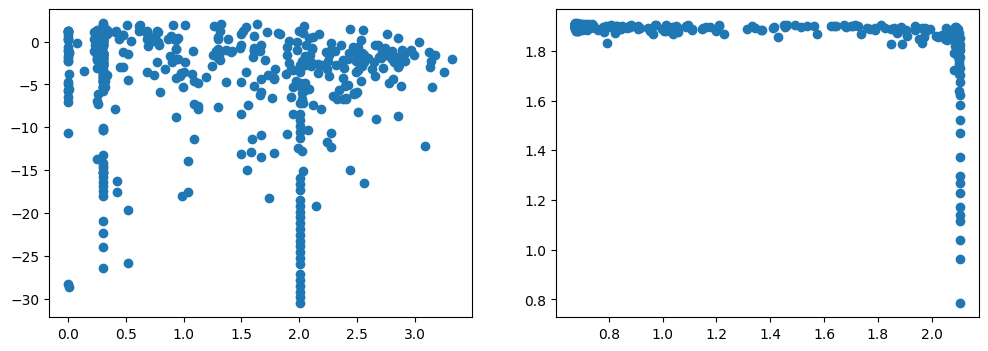

In [25]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12,4))
ax[0].scatter(df[df['Class']==1]['Amount'], df[df['Class']==1]['V1'])
ax[1].scatter(gen_df['Amount'], gen_df['V1'])
plt.show()

In [24]:
import tensorflow as tf

inputs = tf.keras.Input(shape=(3,))
x = tf.keras.layers.Dense(4, activation=tf.nn.relu)(inputs)
outputs = tf.keras.layers.Dense(5, activation=tf.nn.softmax)(x)
model = tf.keras.Model(inputs=inputs, outputs=outputs)